# Alvin Cheung

# ATCF data found here: https://ftp.nhc.noaa.gov/atcf/archive/ 

# This program reads in ATCF a and b decks and performs a verification of models to best-track following NHC verification procedures found here: https://www.nhc.noaa.gov/verification/verify2.shtml. 

# To find model name acronyms, use this link: https://ftp.nhc.noaa.gov/atcf/docs/nhc_techlist.dat

# Documentation: https://www.nrlmry.navy.mil/atcf_web/docs/database/new/abdeck.txt

# We define RI as 30kt increase over 24 hr, similar to many past studies! We go forward in time 24 hour v(t + delta 24 h) - v(t) like (Kaplan and DeMaria 2003)

# September 2022 Storms:

1. AL052022 - Hurricane DANIELLE
2. AL062022 - Hurricane EARL
3. AL072022 - Major Hurricane FIONA
4. AL082022 - Tropical Storm GASTON
5. AL092022 - Major Hurricane IAN
6. AL102022 - Tropical Storm HERMINE

# Cases from Judt et al. (2023)

Sprint RI-

1. AL192020 - Hurricane SALLY

Marathon RI-

2. AL072010 - Major Hurricane EARL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import UnivariateSpline

In [2]:
a_b_deck_cols = ['BASIN', 'CY', 'YYYYMMDDHH', 'TECHNUM/MIN', 'TECH', 'TAU', 'LatN/S',
 'LonE/W', 'VMAX', 'MSLP', 'TY', 'RAD', 'WINDCODE', 'RAD1', 'RAD2',
 'RAD3', 'RAD4', 'POUTER', 'ROUTER', 'RMW', 'GUSTS', 'EYE', 'SUBREGION',
 'MAXSEAS', 'INITIALS', 'DIR', 'SPEED', 'STORMNAME', 'DEPTH', 'SEAS', 
 'SEASCODE', 'SEAS1', 'SEAS2', 'SEAS3', 'SEAS4', 'USERDEFINED', 'userdata']

In [3]:
# Change file names to view different storms

read_a_deck = pd.read_csv('/Users/a98alvin/Documents/UMD/RI/atcf/archive/2010/aal072010.dat.gz',header=None,
           usecols = range(0,30),names=a_b_deck_cols[0:30])
model_names = read_a_deck['TECH'].unique()
read_b_deck = pd.read_csv('/Users/a98alvin/Documents/UMD/RI/atcf/archive/2010/bal072010.dat.gz',header=None,
                         usecols = range(0,30),names=a_b_deck_cols[0:30])

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Select radius
#---------------------------------------------------------------------------------------------
rad = 34 # 34, 50, 64 possible (setting)
#---------------------------------------------------------------------------------------------
best_track = read_b_deck[read_b_deck['RAD'] == rad] # best track before taking out technum rows
best_track = best_track[best_track['TECHNUM/MIN'] == '   '] # best track after taking out technum rows

middle_index = best_track['STORMNAME'].index[int(
    np.ceil(len(best_track['STORMNAME'].index)/2))] # We do middle index to pick the storm name, not a TD number

sname = best_track['STORMNAME'][middle_index].strip()


In [5]:
intensity = best_track['VMAX']
datetimes_b = pd.to_datetime(best_track['YYYYMMDDHH'],format='%Y%m%d%H',utc=True)
intensity.index = datetimes_b
intensity_syn = intensity[(intensity.index.hour == 0) | (intensity.index.hour == 6)| (intensity.index.hour == 12)|
                     (intensity.index.hour == 18)] # Pick only synoptic times (regular forecasts only!)

In [6]:
def my_fun(x):
#     print(x)
    return x.iloc[-1] - x.iloc[0]

# timedelta(hours=30) calls 5 time periods, which is one day later. print(x) demonstrates this.
# shift(-4) allows for forward calculating since we want to find time where RI period begins!
# shift(-2) allows for center calculating since we want to find time where RI period begins!

rolling_diff = intensity_syn.rolling(window=timedelta(hours=30),min_periods=5,center=False).apply(my_fun).shift(-4)

rolling_diff_secs = rolling_diff.dropna().index.astype(np.int64)// 10 ** 9

spl = UnivariateSpline(rolling_diff_secs, rolling_diff.dropna(),k=3,s=0)
spl_time = np.linspace(rolling_diff_secs[0],rolling_diff_secs[-1],100000)
diff_spl = spl(spl_time)
pd_spl = pd.to_datetime(spl_time,unit='s',utc=True)

In [7]:
threshold_crossings = np.diff(diff_spl >= 30, prepend=False)
up_cross = np.argwhere(threshold_crossings)[::2,0]  # Upward crossings
down_cross = np.argwhere(threshold_crossings)[1::2,0]  # Downward crossings

if len(up_cross) == 0:
    ri = 0 # no RI found in this storm!
else:
    ri = 1
    
# if no ri, select model initialization time:

#---------------------------------------------------------------------------------------------
model_run_num_for_no_ri = 5 # setting
#---------------------------------------------------------------------------------------------

# Select model name
#---------------------------------------------------------------------------------------------
model_name = 'HWRF' # setting
#---------------------------------------------------------------------------------------------

a_deck_single_model = read_a_deck[read_a_deck['TECH'].str.contains(model_name)] # Call model

datetimes_a = pd.to_datetime(a_deck_single_model['YYYYMMDDHH'],format='%Y%m%d%H',utc=True).unique()

# Find nearest time to model initialization

if ri == 1: # settings
    #---------------------------------------------------------------------------------------------
    h_prior_to_RI = 24 # Number of hours prior to RI for model run we want to look at.

    RI_Number = 1 # If more than one RI period (1 = first RI period).
    #---------------------------------------------------------------------------------------------
    
    time_diff = pd_spl[up_cross][0] - datetimes_a
    time_ind = np.where(time_diff == min(abs(time_diff)))[0]
    RI_time = datetimes_a[time_ind] - timedelta(hours=h_prior_to_RI)
    strf_RI = RI_time[RI_Number - 1].strftime('%Y%m%d%H')

    # Select model initialization time

    single_init_model = a_deck_single_model[a_deck_single_model['YYYYMMDDHH'] == int(strf_RI)]
else: # If no RI, just pick the first time (can be changed)
    single_init_model = a_deck_single_model[a_deck_single_model['YYYYMMDDHH'] == 
                                            a_deck_single_model['YYYYMMDDHH'].unique()[model_run_num_for_no_ri]]

# Select Radius

single_init_model = single_init_model[single_init_model['RAD'] == rad]

In [8]:
model_fore_datetimes = []

if ri == 1:
    for i in range(len(single_init_model)):
        current_forecast_time = RI_time[RI_Number - 1] + timedelta(hours=int((single_init_model['TAU'].values)[i]))
        model_fore_datetimes.append(current_forecast_time)
else: 
    for i in range(len(single_init_model)):
        current_forecast_time = datetimes_a[model_run_num_for_no_ri] + timedelta(hours=int((single_init_model['TAU'].values)[i]))
        model_fore_datetimes.append(current_forecast_time)
    
single_init_model.index = model_fore_datetimes

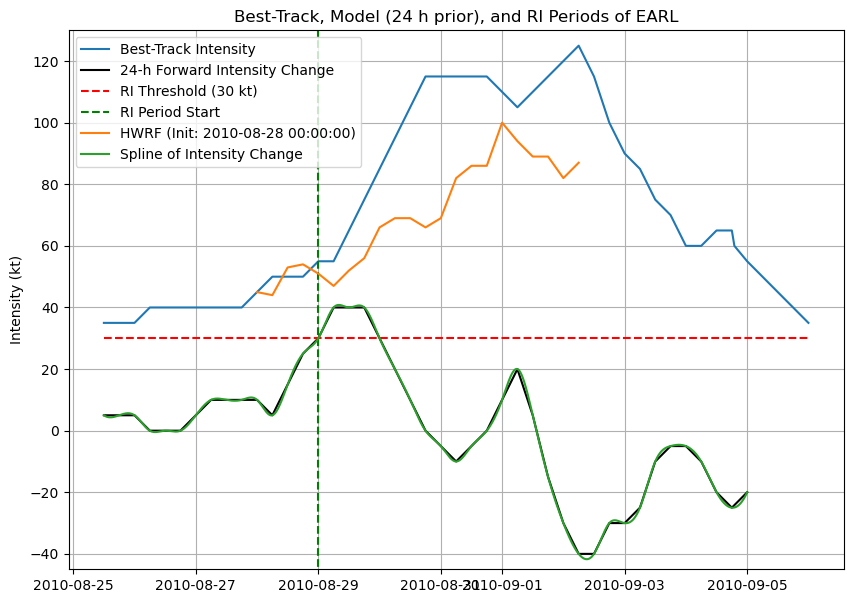

In [9]:
plt.figure(figsize=(10,7))
ax1 = plt.axes()
ax1.grid()
ax1.plot(intensity,label='Best-Track Intensity') # plot best-track
ax1.plot(rolling_diff,'-k',label='24-h Forward Intensity Change') # plot rolling difference
ax1.hlines(30,intensity.index[0],
           intensity.index[-1],'r',linestyle='dashed',label='RI Threshold (30 kt)') # plot RI threshold

plt.vlines(pd_spl[up_cross],rolling_diff.min() - 15,intensity.max() + 15,linestyle='dashed',color='green',
          label='RI Period Start') # plot RI start period

if ri ==1:
    init_str = str(RI_time[RI_Number - 1])[0:19] # string for model init time
    plt.plot(single_init_model['VMAX'],label=model_name+' (Init: '+init_str+')') # plot model forecast
else: 
    no_ri_init_str = str(datetimes_a[model_run_num_for_no_ri])[0:19]
    plt.plot(single_init_model['VMAX'],label=model_name+' (Init: '+no_ri_init_str+')') # plot model forecast

plt.plot(pd_spl,diff_spl,label='Spline of Intensity Change')

if intensity.max() > single_init_model['VMAX'].max():
    plt.ylim(rolling_diff.min()-5,intensity.max() + 5)
else: 
    plt.ylim(rolling_diff.min()-5,single_init_model['VMAX'].max() + 5)

plt.ylabel('Intensity (kt)')

if ri == 1:
    plt.title('Best-Track, Model ('+str(h_prior_to_RI)+' h prior), and RI Periods of ' + sname)
else:
    plt.title('Best-Track, Model, and RI Periods of ' + sname)


plt.legend()
# RI period would begin when black line goes above red dashed line
# and end 24 hours after black line goes below red dashed line


